In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

import pennylane as qml
import pennylane.numpy as np
from mitiq.zne.inference import RichardsonFactory
from mitiq.zne.scaling import fold_global
import pandas as pd

import util

SIMULATION_MODE = True    # running from local or real hardware
noise_strengths = np.linspace(0.0,1.0,11)
scale_factors = range(3,7)   # due to range of python doesn't include the last element, starting from 3 means the list of scale factors will be range(1,3) = [1,2]
ibmqx_token="xxx"

Zero Noise Extrapolation (ZNE) is a powerful technique in quantum computing aimed at mitigating errors arising from noise and imperfections in quantum hardware. By leveraging measurements from noisy quantum circuits, ZNE algorithms can estimate and correct errors, ultimately enhancing the reliability and accuracy of quantum computations.

In this notebook, I 
- Implement ZNE from scratch
- Compare with the result of Mitiq implementation 
- Experiment with ZNE algorithms to optimize its hyperparameters

##  Build a simple noise model with depolarizing noise

In [2]:
if SIMULATION_MODE:
    dev_noise_free = qml.device("default.mixed", wires=2)
    devs = [qml.transforms.insert(dev_noise_free,
                                  qml.DepolarizingChannel,
                                  noise_strength) 
            for noise_strength in noise_strengths]
else:
    dev = qml.device('qiskit.ibmq', wires=2, 
                     backend='ibm_kyoto', ibmqx_token=ibmqx_token)
noise_less_dev = qml.device("default.qubit", wires=2)

In [3]:
def circuit():
    """
    @A circuit preparing a Bell state
    """
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

## Apply folding method and different extrapolation

We define `results` dataframe to save our experiments. It will have the structure like this

|    |   scale_factor |   noise_strength | extrapolation_type   |    value |
|---:|---------------:|-----------------:|:---------------------|---------:|
|  0 |              1 |              0.1 | linear               | 0.375556 |
|  1 |              1 |              0.1 | polynomial           | 0.187778 |
|  2 |              1 |              0.1 | reference_polynomial | 0.751111 |



In [4]:
dict_list = []
for i_dev, dev in enumerate(devs):   # noise level loop
    noise_lvl = noise_strengths[i_dev]
    device_circuit = qml.QNode(circuit, dev)
    for max_scale_factor in scale_factors:   # max scale factor loop
        # unitary folding
        result_per_noise_level = []
        for scale_factor in range(1, max_scale_factor):   # loop from 1 to current max scale factor
            ops, measurements = util.unitary_fold(device_circuit, scale_factor)
            folded_circuit = util.circuit_from_ops(dev, ops, measurements)
            result_per_noise_level.append(float(folded_circuit))
        # done unitary folding

        # extrapolation with the scale factors up to i_scale+1 and current result_per_noise_level
        
        dict_list.append(util.create_record('linear', noise_lvl, max_scale_factor,
                      float(util.linear_extrapolation(range(1, max_scale_factor), result_per_noise_level))))
        #dict_list.append(util.create_record('exp', noise_lvl, scale_factor,
        #                 float(util.exponential_extraplation(range(1, max_scale_factor), result_per_noise_level))))
        dict_list.append(util.create_record('polynomial', noise_lvl, max_scale_factor,
                        float(util.polynomial_extraplation(range(1, max_scale_factor), result_per_noise_level, max_scale_factor-2))))  # scale_factor is in range(1, scale_factor), so its max value is scale_factor-1. Now we -1 once more because of the math in polynomial extrapolation
        
        # reference implementation
        error_mitigated_device_circuit = qml.transforms.mitigate_with_zne(
            device_circuit,
            range(1, max_scale_factor),
            folding = fold_global,    
            extrapolate = RichardsonFactory.extrapolate,
        )
        dict_list.append(util.create_record('reference_polynomial', noise_lvl, max_scale_factor,
                           float(error_mitigated_device_circuit())))

In [5]:
results = pd.DataFrame(dict_list)

## Research questions

It is natural to ask which method and which fold to use when. To answer that we would plot the `results` dictionary

In [6]:
results['noise_strength'] = results['noise_strength'].astype(float)

In [7]:
line_style_plot = {
    'reference_polynomial': '--',
    'polynomial': ':',
    'linear': '-.',
    'exp': '-'
}

linewidth_plot = {
    'reference_polynomial': 5,
    'polynomial': 3,
    'linear': 1,
    'exp': '1'
}

alpha_plot = {
    'reference_polynomial': 0.5,
    'polynomial': 1,
    'linear': 1,
    'exp': 1    
}

color_plot = {
    'reference_polynomial': 'green',
    'polynomial': 'black',
    'linear': 'red',
    'exp': 'blue'
}

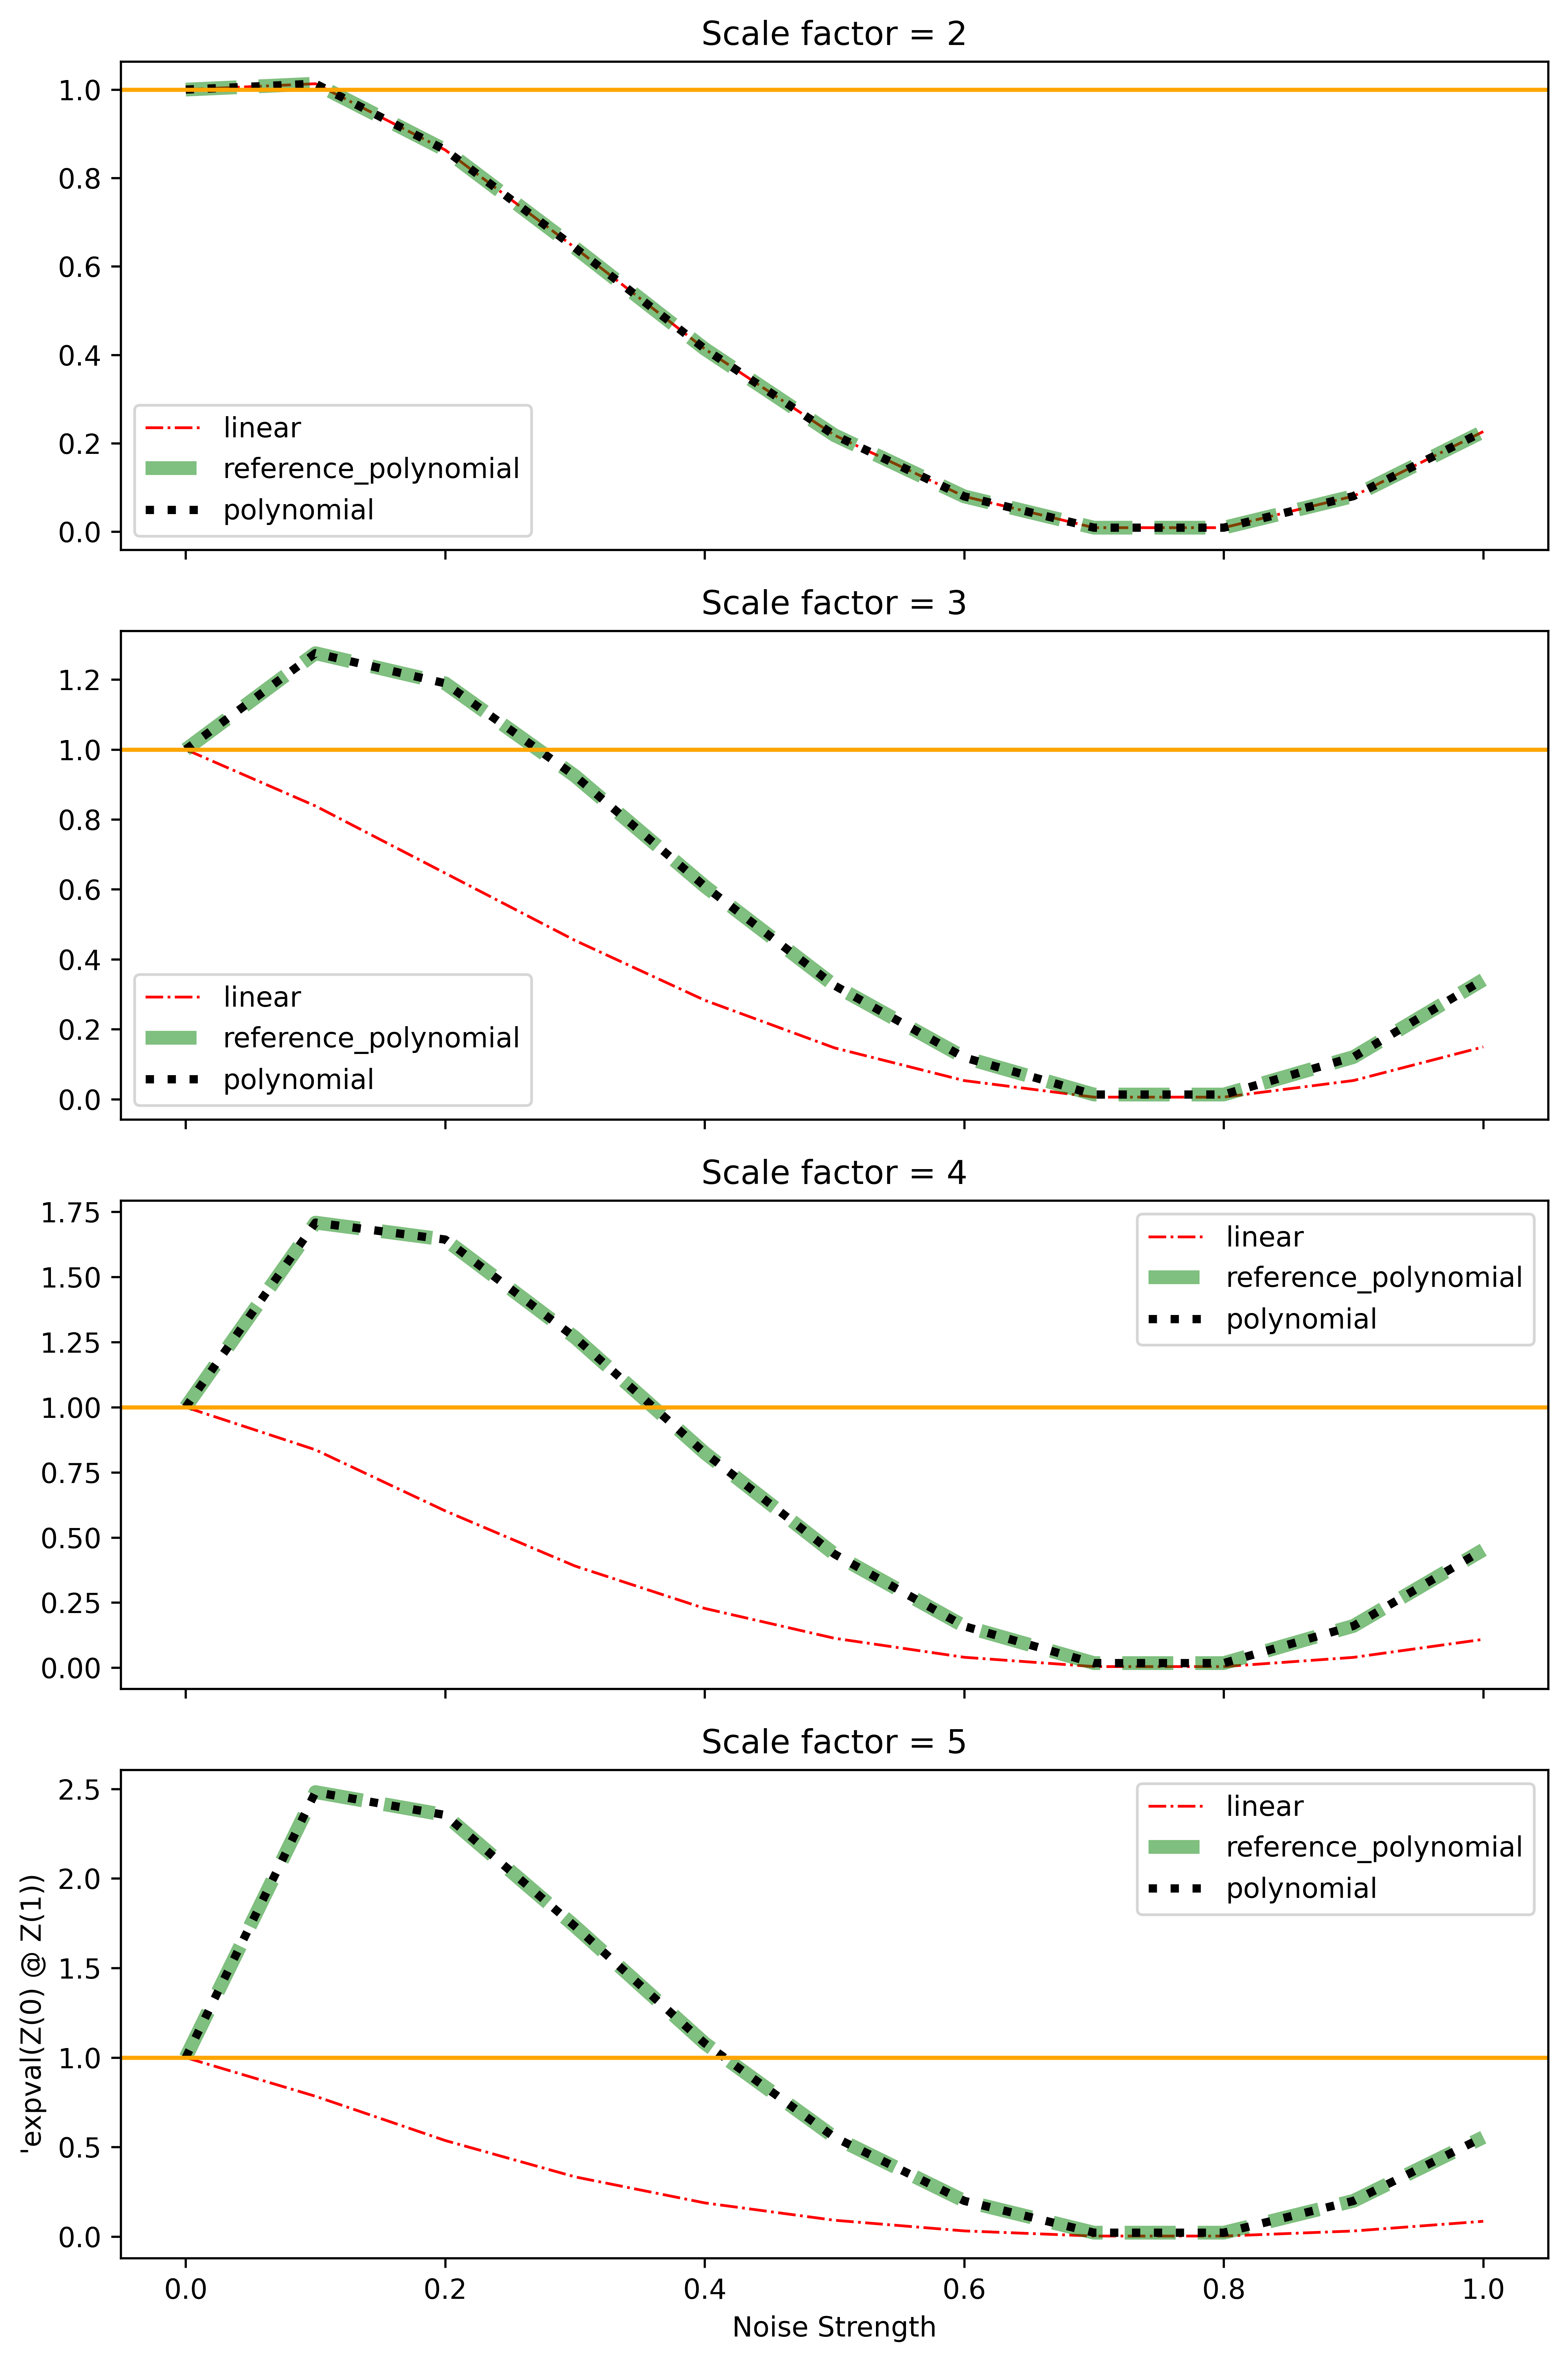

In [8]:
# Create subplots

fig, axs = plt.subplots(nrows=len(scale_factors), ncols=1, sharex=True)

# Plot data for each 'extrapolation_type'
for s_factor_index, s_factor in enumerate(scale_factors):
    for extrapolation_type in set(results['extrapolation_type']):
        df = results[(results['extrapolation_type'] == extrapolation_type) & (results["scale_factor"] == s_factor)]      
        df.plot(x='noise_strength', y='value', figsize=(8, 12), ax=axs[s_factor_index], 
                label=extrapolation_type, linestyle=line_style_plot[extrapolation_type],
                linewidth=linewidth_plot[extrapolation_type], alpha=alpha_plot[extrapolation_type],
                color=color_plot[extrapolation_type],
               )    
    axs[s_factor_index].axhline(y = 1, color = 'orange', linestyle = '-', label="Zero noise result") 
    axs[s_factor_index].set_title(f'Scale factor = {s_factor-1}')
    axs[s_factor_index].xaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))


plt.xlabel("Noise Strength")
plt.ylabel("'expval(Z(0) @ Z(1))", loc='center')
plt.tight_layout()

plt.show()

In the plot below, the orange line is the expected value if there are no noise in the circuit